# Imports and Configs

In [ ]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from web3 import Web3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('C:/Users/lybra/github/panoptic/stylesheet/panoptic-dark-16_9.mplstyle')

dir = "[Your_Directory_Here]" # Replace with your own directory where your abi files and this notebook are contained
'''Note: you'll also need to replace the provider with your Ethereum provider in get_provider() later on in the code'''

In [2]:
'''Subgraph urls for each Panoptic deployment on each chain'''
url_ethereum_v3 = 'https://api.goldsky.com/api/public/project_cl9gc21q105380hxuh8ks53k3/subgraphs/panoptic-subgraph-mainnet/prod/gn' # Panoptic v1 on Uni v3, eth mainnet

'''Panoptic pool names ({TOKEN0}-{TOKEN1}-{FEE TIER}bps)'''
pool_selector_eth_usdc_30 = 'USDC-WETH-30bps'
pool_selector_btc_eth_30 = 'WBTC-WETH-30bps'
pool_selector_cult_weth_100 = 'CULT-WETH-100bps'
pool_selector_weth_eigen_30 = 'WETH-EIGEN-30bps'
pool_selector_waac_weth_100 = 'WAAC-WETH-100bps'

# Change this to the chain and pool you want to analyze
url = url_ethereum_v3
pool_selector = pool_selector_eth_usdc_30

'''Pool level parameters'''
UI_DEFAULT_ASSET = 1 # If 1, then token1 is the default asset on UI and token0 is the default quote on UI

if UI_DEFAULT_ASSET == 0:
    INVERSE_PRICE = False
else:
    INVERSE_PRICE = True

# Deposits & Withdrawals

### Deposits

In [3]:
query_deposit = gql("""
  query GetTradeData (
    $skip: Int        
  ) {
    collateralDeposits (
      first: 1000 
      skip: $skip
    ) {
      blockNumber
      timestamp
      pool {
          feeTier
          token0 { symbol }
          token1 { symbol }
      }
      collateral {
          token { 
            symbol
            decimals
          }
      }
      owner {
        id
      }
      assets
      shares
    }
  }
""")

def get_deposits(url) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
  '''Uses Panoptic subgraph to fetch deposit transactions'''
  client = Client(
    transport=RequestsHTTPTransport(
    url=url,
    verify=True,
    retries=5,
  ))

  all_results = []
  skip = 0
  my_query = query_deposit
  while True:
      params = {"skip": skip}
      try:
          result = client.execute(my_query, variable_values=params)
          print(result)

          if not result['collateralDeposits']:
              break

          all_results.extend(result['collateralDeposits'])
          skip += 1000

      except Exception as ex:
          print(f"got exception for {url} while querying data:", ex)
          continue
      
  result = all_results
  deposits = pd.DataFrame(result)

  deposits['owner_id'] = deposits['owner'].apply(lambda x: x['id'])
  deposits = deposits.drop(columns=['owner'])

  deposits['token'] = deposits['collateral'].apply(lambda x: x['token']['symbol'])
  deposits['decimals'] = deposits['collateral'].apply(lambda x: x['token']['decimals'])
  deposits = deposits.drop(columns=['collateral'])

  deposits['pool'] = deposits['pool'].apply(lambda x: f"{x['token0']['symbol']}-{x['token1']['symbol']}-{int(x['feeTier'])//100}bps")
  grouped = deposits.groupby('pool')
  deposits_pools = {pool: group_df for pool, group_df in grouped}

  deposits = deposits.sort_values(by = 'timestamp')

  # Clean deposit/withdrawal data'
  try:
      deposits_pools[pool_selector]['assets'] = pd.to_numeric(deposits_pools[pool_selector]['assets'], errors='coerce')
      deposits_pools[pool_selector]['decimals'] = pd.to_numeric(deposits_pools[pool_selector]['decimals'], errors='coerce')
      deposits_pools[pool_selector]['assets'] /= 10 ** deposits_pools[pool_selector]['decimals']
      deposits_pools[pool_selector]['date'] = pd.to_datetime(pd.to_datetime(deposits_pools[pool_selector]['timestamp'], unit='s'))
  except KeyError:
      print('There are no deposits for this market')

  return deposits, deposits_pools

In [4]:
(deposits, deposits_pools) = get_deposits(url)

print(f'Number of unique depositors: {len(deposits.owner_id.unique())}')

{'collateralDeposits': [{'blockNumber': '21790799', 'timestamp': '1738885127', 'pool': {'feeTier': '3000', 'token0': {'symbol': 'USDC'}, 'token1': {'symbol': 'WETH'}}, 'collateral': {'token': {'symbol': 'WETH', 'decimals': '18'}}, 'owner': {'id': '0x6d8cca3e5e6bf056654594a0d0856b23ce02ad12'}, 'assets': '1100000000000000000', 'shares': '1079827299464192522864248'}, {'blockNumber': '21805148', 'timestamp': '1739058191', 'pool': {'feeTier': '3000', 'token0': {'symbol': 'USDC'}, 'token1': {'symbol': 'WETH'}}, 'collateral': {'token': {'symbol': 'WETH', 'decimals': '18'}}, 'owner': {'id': '0x24ddc23daad52477c0da5fdfb65d74e275726117'}, 'assets': '470000000000000000', 'shares': '461348520424166810063722'}, {'blockNumber': '21823480', 'timestamp': '1739279291', 'pool': {'feeTier': '3000', 'token0': {'symbol': 'WBTC'}, 'token1': {'symbol': 'WETH'}}, 'collateral': {'token': {'symbol': 'WBTC', 'decimals': '8'}}, 'owner': {'id': '0xe7c3fd5023d1b267d9989a675fca086a88aaad2e'}, 'assets': '464164', 'sh

In [5]:
deposits.sort_values(by='timestamp').tail()

,blockNumber,timestamp,pool,assets,shares,owner_id,token,decimals
283,21827464,1739327375,USDC-WETH-30bps,1096342255191617258,1076069950744962373351014,0x487447da663188250358ab2e8d5201411d69c36a,WETH,18
271,21827684,1739330015,USDC-WETH-30bps,125000000000000000,122687481270747418133358,0xe457669a1ba404ab6b553d620a6fcbe9edeee756,WETH,18
528,21829790,1739355815,USDC-WETH-30bps,503968200,491716150300726,0xf002fcaf8a060808ed39d04e6ff92425080a71d7,USDC,6
423,21830267,1739361587,USDC-WETH-30bps,3497445855111816380,3432738877910012915724084,0xf46ca31613fa3ed6a1b2bea995dc4f5b90c1b496,WETH,18
390,21831527,1739376887,WBTC-WETH-30bps,100000000000000000,98245231884444915824161,0xe457669a1ba404ab6b553d620a6fcbe9edeee756,WETH,18


### Withdrawals

In [6]:
query_withdrawal = gql("""
  query GetTradeData {
    collateralWithdraws {
      blockNumber
      timestamp
      owner {
        id
      }
      pool {
          feeTier
          token0 { symbol }
          token1 { symbol }
      }
      collateral {
          token { 
            symbol
            decimals
          }
      }
      assets
      shares
    }
  }
""")

In [7]:
def get_withdrawals(url) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
    '''Uses Panoptic subgraph to fetch withdrawal transactions'''
    client = Client(
        transport=RequestsHTTPTransport(
        url=url,
        verify=True,
        retries=5,
    ))
    # TODO: implement skips in case there are >1000 withdrawal txs
    my_query = query_withdrawal

    try:
        result = client.execute(my_query)
        print(result)
    except Exception as ex:
        print("got exception while querying data:", ex)
        raise BaseException("Exception while querying data:", ex)
    
    result = result['collateralWithdraws']
    withdrawals = pd.DataFrame(result)

    withdrawals['owner_id'] = withdrawals['owner'].apply(lambda x: x['id'])
    withdrawals = withdrawals.drop(columns=['owner'])


    withdrawals['token'] = withdrawals['collateral'].apply(lambda x: x['token']['symbol'])
    withdrawals['decimals'] = withdrawals['collateral'].apply(lambda x: x['token']['decimals'])
    withdrawals = withdrawals.drop(columns=['collateral'])

    withdrawals['pool'] = withdrawals['pool'].apply(lambda x: f"{x['token0']['symbol']}-{x['token1']['symbol']}-{int(x['feeTier'])//100}bps")
    grouped = withdrawals.groupby('pool')
    withdrawals_pools = {pool: group_df for pool, group_df in grouped}

    try:
        withdrawals_pools[pool_selector]['date'] = pd.to_datetime(pd.to_datetime(withdrawals_pools[pool_selector]['timestamp'], unit='s'))
        withdrawals_pools[pool_selector]['assets'] = pd.to_numeric(withdrawals_pools[pool_selector]['assets'], errors='coerce')
        withdrawals_pools[pool_selector]['decimals'] = pd.to_numeric(withdrawals_pools[pool_selector]['decimals'], errors='coerce')
        withdrawals_pools[pool_selector]['assets'] /= 10 ** withdrawals_pools[pool_selector]['decimals']
    except KeyError:
        print('There are no withdrawals for this market')

    return withdrawals, withdrawals_pools

In [8]:
(withdrawals, withdrawals_pools) = get_withdrawals(url)

withdrawals.sort_values(by='timestamp').tail()

{'collateralWithdraws': [{'blockNumber': '21727170', 'timestamp': '1738117343', 'owner': {'id': '0x3eb7ff01ae4d9f1c10953029934555837eb95ee5'}, 'pool': {'feeTier': '3000', 'token0': {'symbol': 'USDC'}, 'token1': {'symbol': 'WETH'}}, 'collateral': {'token': {'symbol': 'WETH', 'decimals': '18'}}, 'assets': '300000000000000000', 'shares': '295282717065327122992798'}, {'blockNumber': '21694692', 'timestamp': '1737725687', 'owner': {'id': '0x654a0048f5db12ce147ce174784cfc71a992a8b1'}, 'pool': {'feeTier': '10000', 'token0': {'symbol': 'CULT'}, 'token1': {'symbol': 'WETH'}}, 'collateral': {'token': {'symbol': 'CULT', 'decimals': '18'}}, 'assets': '4700648439892002874094741', 'shares': '4660850157856267813513068473252'}, {'blockNumber': '21777588', 'timestamp': '1738725827', 'owner': {'id': '0xbac766deb3fa0b11403c687d1715a1ea1323580e'}, 'pool': {'feeTier': '3000', 'token0': {'symbol': 'USDC'}, 'token1': {'symbol': 'WETH'}}, 'collateral': {'token': {'symbol': 'USDC', 'decimals': '6'}}, 'assets':

,blockNumber,timestamp,pool,assets,shares,owner_id,token,decimals
29,21796364,1738952219,WETH-EIGEN-30bps,96907745338610247,96662132172166029187587,0xfad85cfb8ba2288df114d4327cd218d04c7d015c,WETH,18
72,21805169,1739058443,USDC-WETH-30bps,100000000000000000,98355564031306164360215,0x44f5380f4c66b3b6a2cf68e0cdda3f8e352cb4d9,WETH,18
21,21823499,1739279519,USDC-WETH-30bps,90000000000000000,88514097521002060881422,0xbac766deb3fa0b11403c687d1715a1ea1323580e,WETH,18
57,21823508,1739279627,USDC-WETH-30bps,250000000,244416560354911,0xbac766deb3fa0b11403c687d1715a1ea1323580e,USDC,6
91,21827105,1739323043,USDC-WETH-30bps,1000000000,977666241419642,0xc57710c8a2a4423e3f052cbca170b0b80300bc87,USDC,6


### Graph Deposits/Withdrawals over Time

C:\Users\lybra\AppData\Local\Temp\ipykernel_28700\1628525805.py:52: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


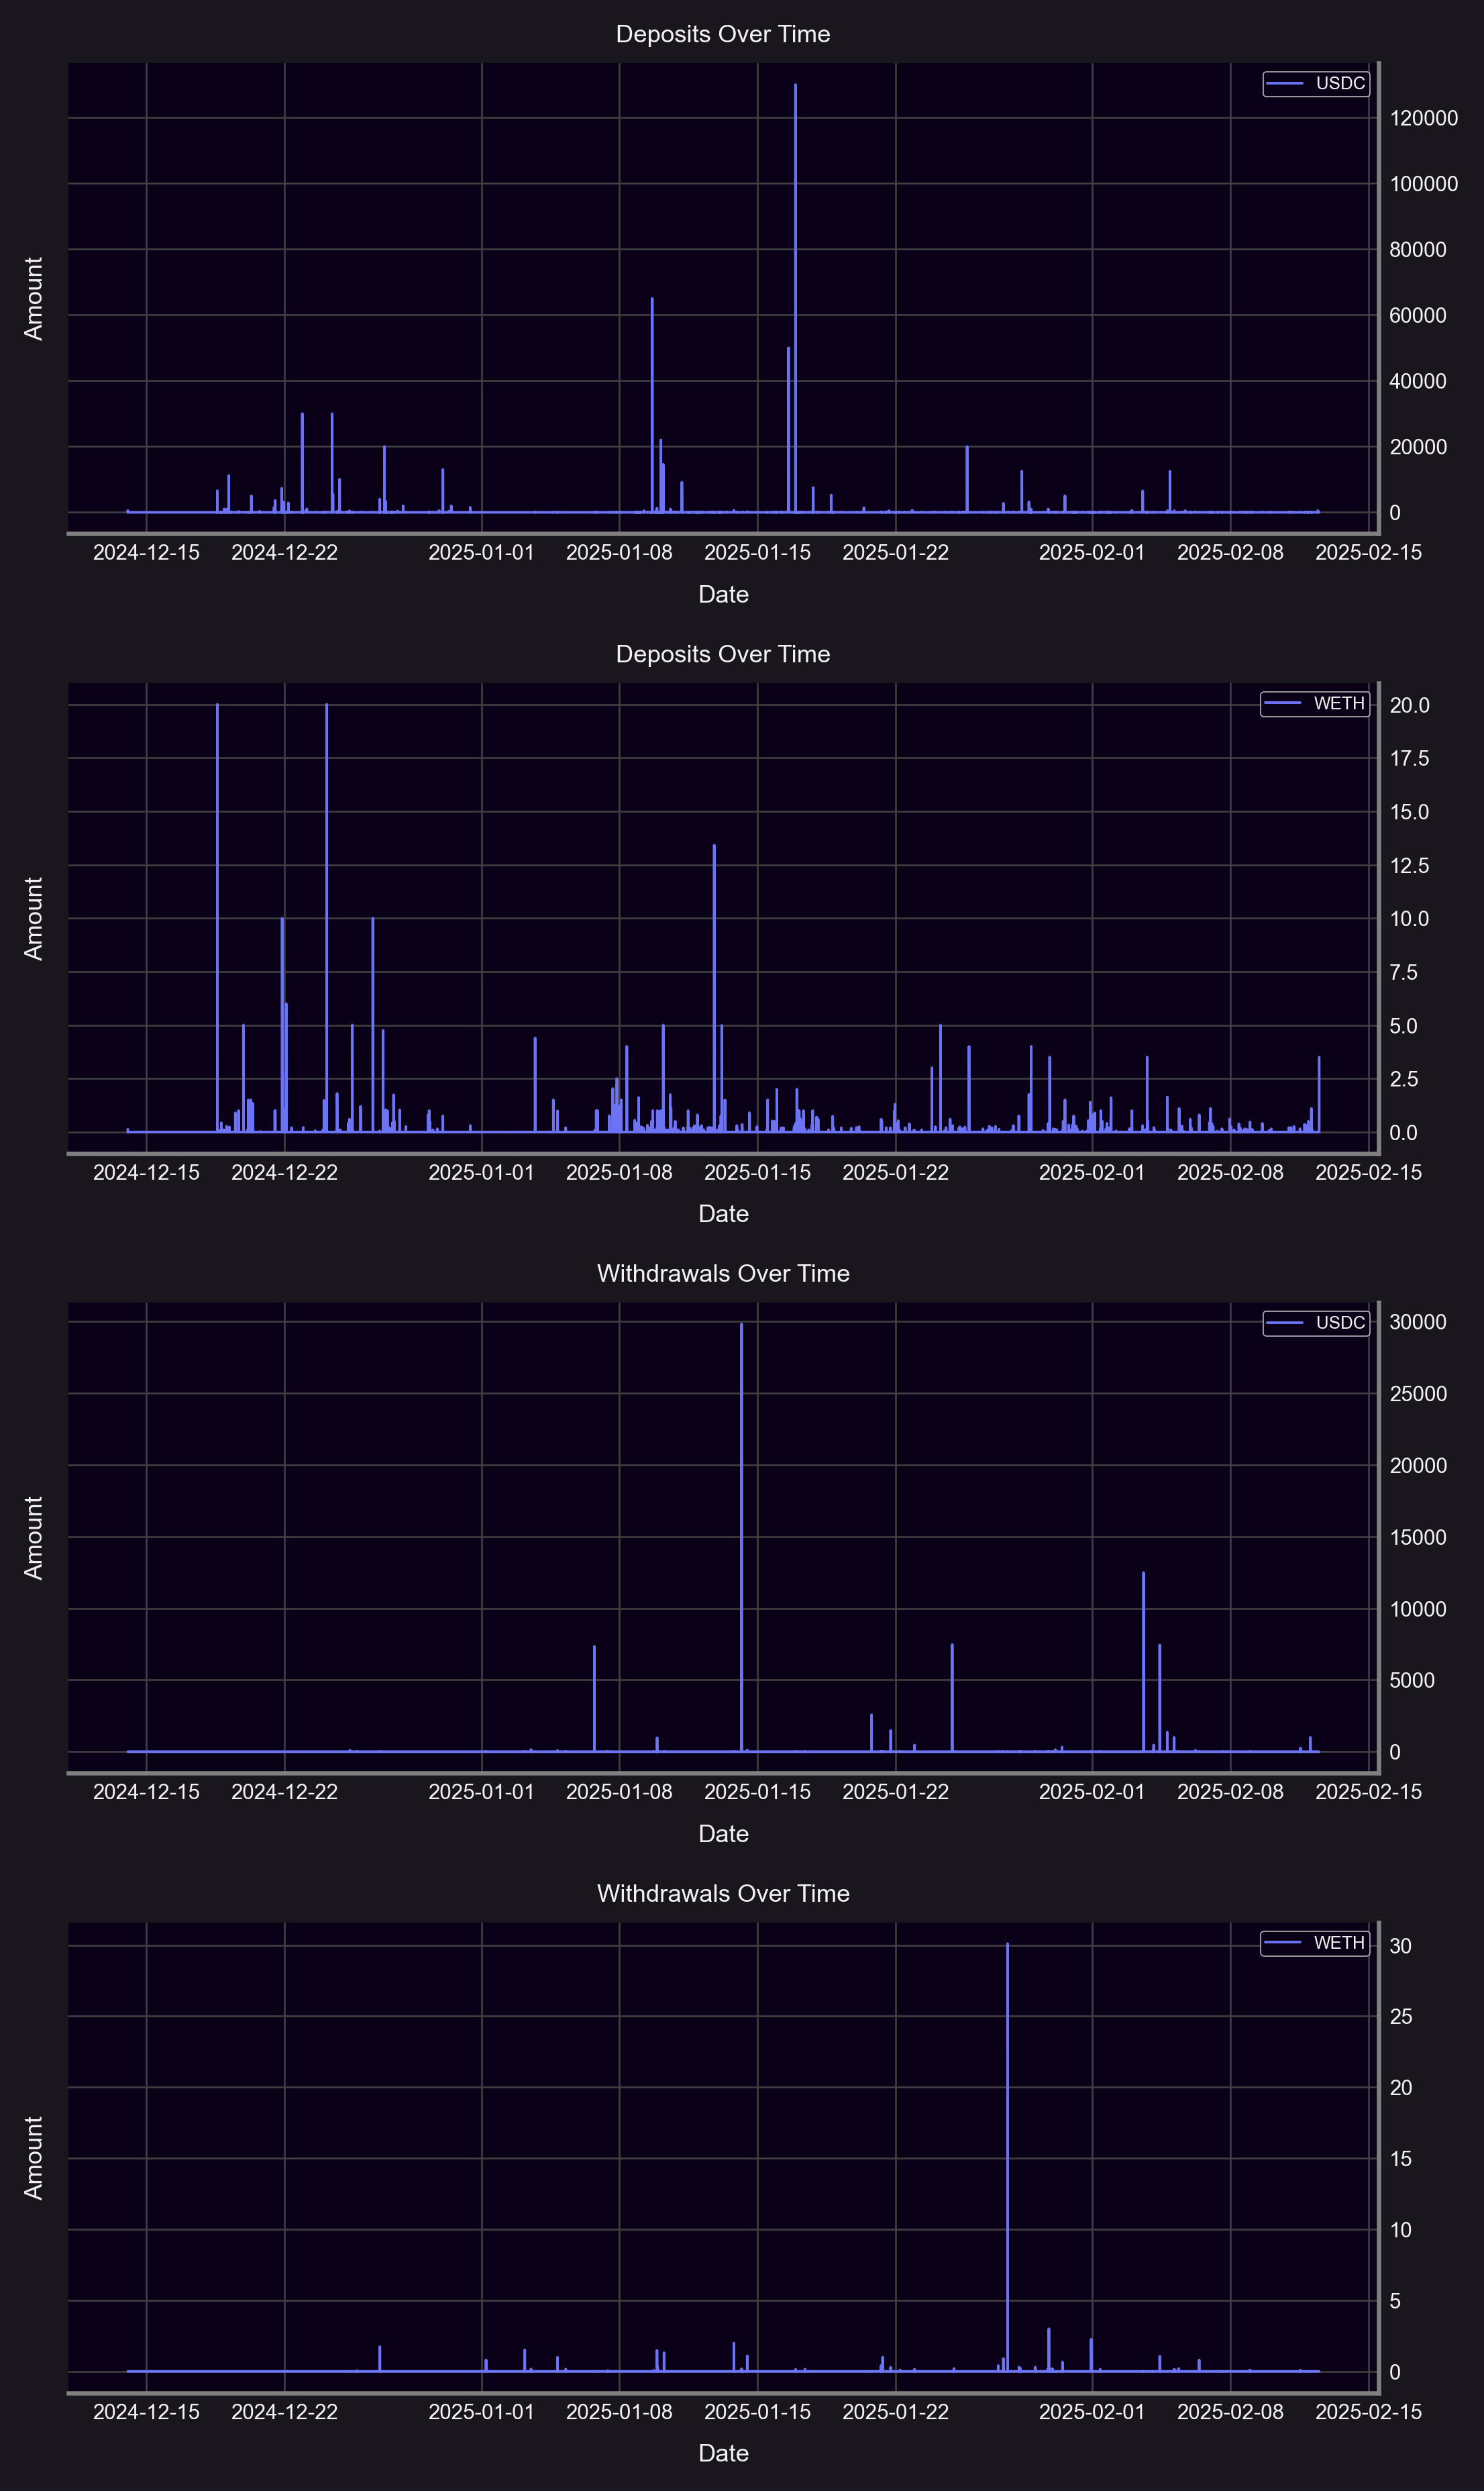

In [9]:
begin_at_epoch_start = True
start_ts = pd.to_datetime(1733011200, unit='s') # Dec 1, 2024 (before Panoptic v1 launched)

fig, ax = plt.subplots(4, 1, figsize=(6, 10))

# Deposits over time
deposit_data = deposits_pools[pool_selector].pivot_table(values='assets', index='date', columns='token', aggfunc='sum').sort_values(by='date')
if begin_at_epoch_start:
    deposit_data = deposit_data[deposit_data.index > start_ts]

first_token = deposit_data.columns[0]
second_token = deposit_data.columns[1]

date_range = pd.date_range(start=deposit_data.index.min(), end=deposit_data.index.max(), freq='s')
deposit_data = deposit_data.reindex(date_range, fill_value=0)

ax[0].plot(deposit_data.index, deposit_data[first_token], label=first_token)
ax[0].set_title('Deposits Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Amount')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(deposit_data.index, deposit_data[second_token], label=second_token)
ax[1].set_title('Deposits Over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Amount')
ax[1].legend()
ax[1].grid(True)

withdrawal_data = withdrawals_pools[pool_selector].pivot_table(values='assets', index='date', columns='token', aggfunc='sum').sort_values(by='date')
if begin_at_epoch_start:
    withdrawal_data = withdrawal_data[withdrawal_data.index > start_ts]
    withdrawals_pools[pool_selector]

withdrawal_data = withdrawal_data.reindex(date_range, fill_value=0)

ax[2].plot(withdrawal_data.index, withdrawal_data[first_token], label=first_token)
ax[2].set_title('Withdrawals Over Time')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Amount')
ax[2].legend()
ax[2].grid(True)

ax[3].plot(withdrawal_data.index, withdrawal_data[second_token], label=second_token)
ax[3].set_title('Withdrawals Over Time')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Amount')
ax[3].legend()
ax[3].grid(True)

plt.tight_layout()
plt.savefig(f"{dir}/deposits_withdrawals.png")
plt.show()

C:\Users\lybra\AppData\Local\Temp\ipykernel_28700\1681305096.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


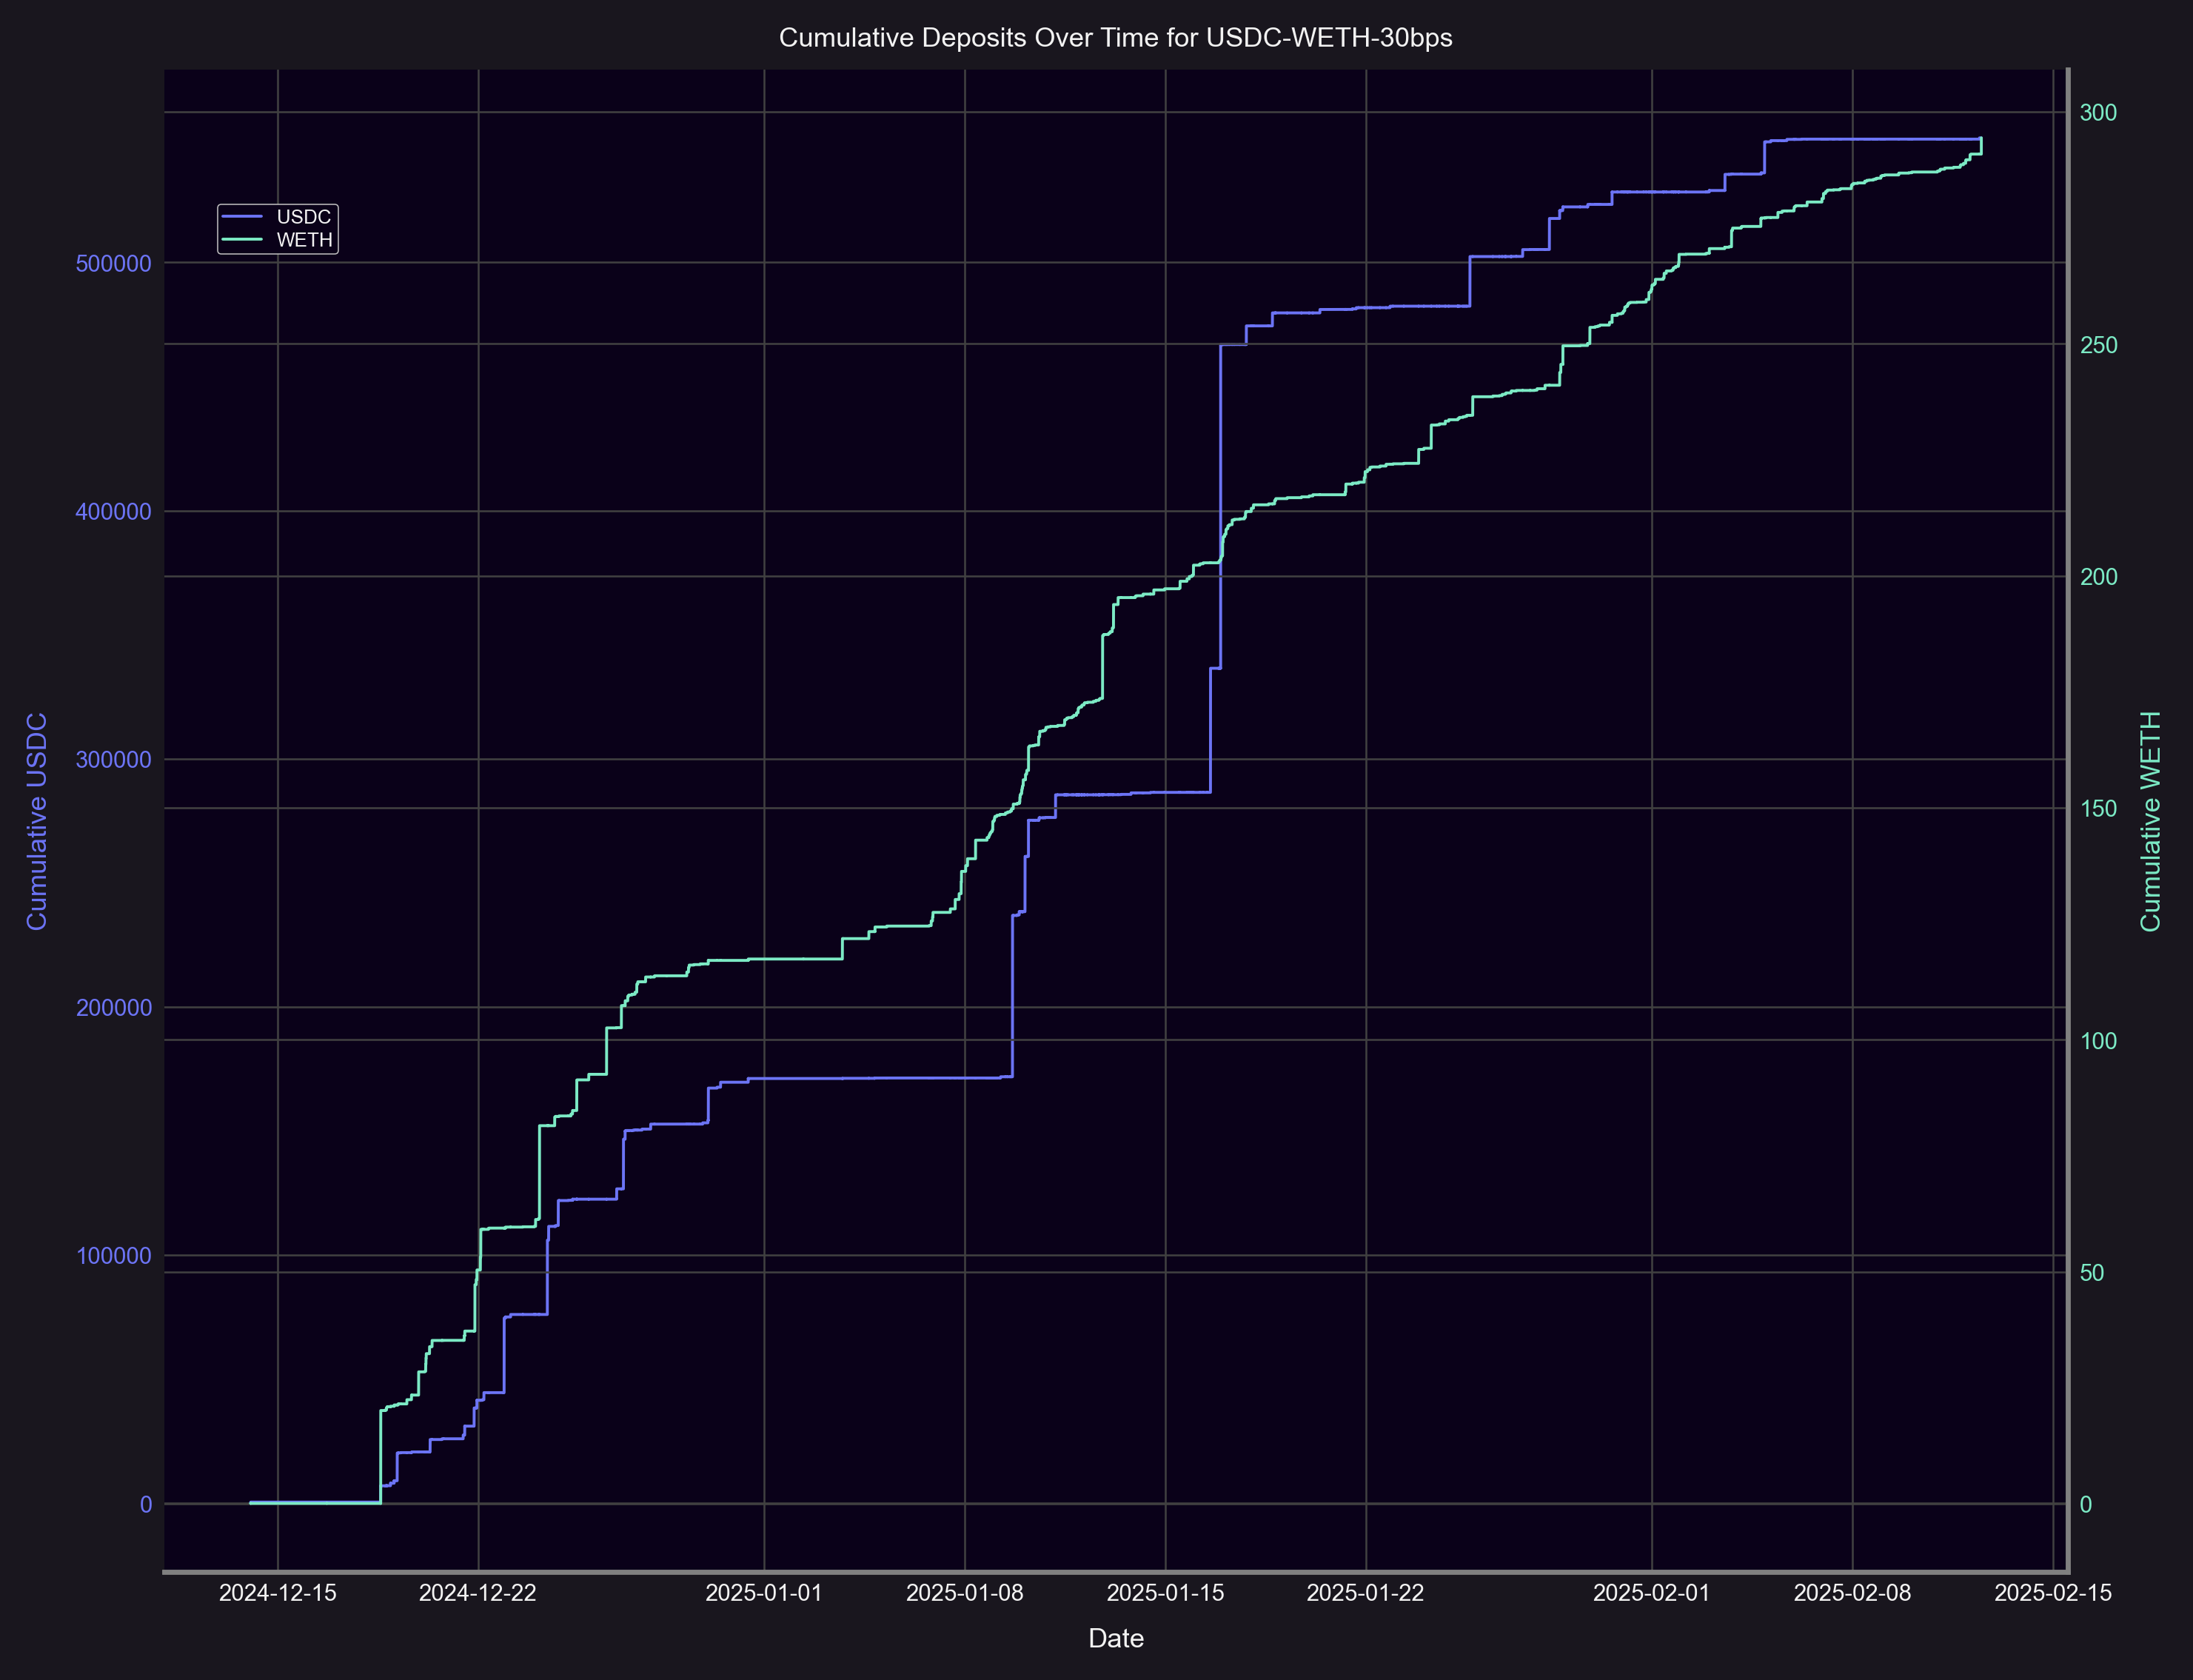

In [10]:
cumulative_deposits = deposit_data.cumsum()

fig, ax1 = plt.subplots(figsize=(8, 6))

colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef']

color1 = colors[0]
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Cumulative {first_token}', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color2 = colors[1]
ax2.set_ylabel(f'Cumulative {second_token}', color=color2)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)

ax1.plot(cumulative_deposits.index, cumulative_deposits[first_token], label=f"{first_token}", color=color1)
ax2.plot(cumulative_deposits.index, cumulative_deposits[second_token], label=f"{second_token}", color=color2)

fig.tight_layout()
plt.title(f'Cumulative Deposits Over Time for {pool_selector}')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.savefig(f"{dir}/cumulative_deposits.png")
plt.show()

# Trade Data

In [ ]:
sym_0, sym_1, fee_tier_name = pool_selector.split('-')
DEC_0 = deposits_pools[pool_selector].loc[deposits_pools[pool_selector]['token'] == sym_0].iloc[0]['decimals']
DEC_1 = deposits_pools[pool_selector].loc[deposits_pools[pool_selector]['token'] == sym_1].iloc[0]['decimals']

panoptic_pool_addresses = {
    'WBTC-WETH-30bps': Web3.to_checksum_address('0x000000000000100921465982d28b37d2006e87fc'),
    'USDC-WETH-30bps': Web3.to_checksum_address('0x000000000000305b8621e2475aee38ab5721d525'),
    'CULT-WETH-100bps': Web3.to_checksum_address('0x000097c4eca5819f78bf60bbc7ff4f3f8f27aed1'),
    'WETH-EIGEN-30bps': Web3.to_checksum_address('0x65377a56426cdffa4838386277699578406c145c'),
    'WAAC-WETH-100bps': Web3.to_checksum_address('0x0000000000007ee9f95090e9dc21e3d61b6997b2'),
}

uniswap_pool_addresses = {
    'WBTC-WETH-30bps': Web3.to_checksum_address('0xCBCdF9626bC03E24f779434178A73a0B4bad62eD'),
    'USDC-WETH-30bps': Web3.to_checksum_address('0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8'),
    'CULT-WETH-100bps': Web3.to_checksum_address('0xc4ce8e63921b8b6cbdb8fcb6bd64cc701fb926f2'),
    'WETH-EIGEN-30bps': Web3.to_checksum_address('0xc2c390c6cd3c4e6c2b70727d35a45e8a072f18ca'),
    'WAAC-WETH-100bps': Web3.to_checksum_address('0xeba623e4f5c7735427a9ef491ecee082dd4bf6ce'),
}

if pool_selector == 'USDC-WETH-30bps':
    DEC_0 = 6 # USDC
    DEC_1 = 18 # WETH
    token_0 = 'USDC'
    token_1 = 'WETH'
    chain = 'Ethereum'
    fee_tier = 30
elif pool_selector == 'WBTC-WETH-30bps':
    DEC_0 = 8 # WBTC
    DEC_1 = 18 # WETH
    token_0 = 'WBTC'
    token_1 = 'WETH'
    chain = 'Ethereum'
    fee_tier = 30
elif pool_selector == 'CULT-WETH-100bps':
    DEC_0 = 18 # CULT
    DEC_1 = 18 # WETH
    token_0 = 'CULT'
    token_1 = 'WETH'
    chain = 'Ethereum'
    fee_tier = 100
elif pool_selector == 'WETH-EIGEN-30bps':
    DEC_0 = 18 # WETH
    DEC_1 = 18 # EIGEN
    token_0 = 'WETH'
    token_1 = 'EIGEN'
    chain = 'Ethereum'
    fee_tier = 30
elif pool_selector == 'WAAC-WETH-100bps':
    DEC_0 = 0 # WAAC
    DEC_1 = 18 # WETH
    token_0 = 'WAAC'
    token_1 = 'WETH'
    chain = 'Ethereum'
    fee_tier = 100

def get_tick_spacing(fee: int) -> int:
    """
    Gets Univ3 tick spacing corresponding to fee-tier

    :fee fee-tier in bps
    """
    spacing = {
        1: 1,
        5: 10,
        30: 60,
        100: 200
    }
    try:
        space = spacing[fee]
    except KeyError:
        return None
    return space

def get_current_tick(block_number):
    return uniswap_pool_contract.functions.slot0().call(block_identifier=block_number)[1] 

def get_provider(chain: str):
    if chain == 'Ethereum':
        provider = 'YOUR_PROVIDER_HERE' # replace with your provider (e.g. Alchemy or Infura)
    return provider

provider = get_provider(chain)
base_rpc_provider = Web3.HTTPProvider(provider)
w3 = Web3(base_rpc_provider)

ts = get_tick_spacing(fee_tier)

panoptic_pool_address = panoptic_pool_addresses[pool_selector]
uniswap_pool_address = uniswap_pool_addresses[pool_selector]

# Read ABI from file
if chain == 'Ethereum':
    panoptic_helper_address = Web3.to_checksum_address('0x95A5fF032C728F7F16e7fBd4F4EA2d0C0623Ffbb')
    SFPM_address = Web3.to_checksum_address('0x0000000000000DEdEDdD16227aA3D836C5753194')

with open(f'{dir}/SFPM_abi.txt', 'r') as abi_file:
    SFPM_abi = abi_file.read()
SFPM_contract = w3.eth.contract(address=SFPM_address, abi=SFPM_abi)

with open(f'{dir}/panoptic_pool_abi.txt', 'r') as abi_file:
    panoptic_pool_abi = abi_file.read()
panoptic_pool_contract = w3.eth.contract(address=panoptic_pool_address, abi=panoptic_pool_abi)

with open(f'{dir}/panoptic_helper_abi.txt', 'r') as abi_file:
    panoptic_helper_abi = abi_file.read()
panoptic_helper_contract = w3.eth.contract(address=panoptic_helper_address, abi=panoptic_helper_abi)

with open(f'{dir}/uniswap_pool_abi.txt', 'r') as abi_file:
    uniswap_pool_abi = abi_file.read()
uniswap_pool_contract = w3.eth.contract(address=uniswap_pool_address, abi=uniswap_pool_abi)

CURRENT_BLOCK = w3.eth.block_number
CURRENT_TICK = get_current_tick(CURRENT_BLOCK)

In [12]:
# $start_timestamp: BigInt! = 1734048000 # Panoptic v1 on eth mainnet
# $end_timestamp: BigInt! = 1740787200 # very far out into the future

query_trade = gql("""
  query GetTradeData(
    $skip: Int
    $start_timestamp: BigInt! = 1734048000
    $end_timestamp: BigInt! = 1740787200
  ) {
    panopticPoolAccounts(
        first: 1000
        where: {
        accountBalances_: {
            createdTimestamp_gt: $start_timestamp
            createdTimestamp_lt: $end_timestamp
        }
        }
    )   {
        accountBalances(
            first: 1000,
            skip: $skip
            where: {
                createdTimestamp_gt: $start_timestamp
                createdTimestamp_lt: $end_timestamp
            }
        ) {
            panopticPoolAccount {
                panopticPool {
                    id
                    feeTier
                    token0 { symbol }
                    token1 { symbol }
                }
            }
            sender {
                id
            }
            tokenId {
                id
            }
            txnOpened {
            ... on OptionMint {
                id
                blockNumber
                timestamp
                hash
                tickAt
                positionSize
                tokenId {
                id
                legs {
                    id
                    strike
                    isLong
                    optionRatio
                    tokenType
                    asset
                    chunk {
                        tickLower
                        tickUpper
                    }
                }
                }
                poolUtilization0
                poolUtilization1
            }
            }
            txnClosed {
            ... on OptionBurn {
                id
                blockNumber
                timestamp
                hash
                positionSize
                tokenId {
                    id
                }
                tickAt
                premium0
                premium1
            }
            }
            legLiquidities {
                liquidity
            }
        }
    }
}
""")

def extract_txn_opened_data(row):
    '''Extract data from txnOpened'''
    if row['txnOpened']:
        return (
            row['txnOpened'].get('id'),
            row['txnOpened'].get('blockNumber'),
            row['txnOpened'].get('timestamp'),
            row['txnOpened'].get('hash'),
            row['txnOpened'].get('tickAt'),
            row['txnOpened'].get('positionSize'),
            row['txnOpened']['tokenId'].get('id'),
            row['txnOpened']['tokenId'].get('legs'),
            row['txnOpened'].get('poolUtilization0'),
            row['txnOpened'].get('poolUtilization1')
        )
    else:
        return (None, None, None, None, None, None, None, None, None, None)

def extract_txn_closed_data(row):
    '''Extract data from txnClosed'''
    if row['txnClosed']:
        return (
            row['txnClosed'].get('id'),
            row['txnClosed'].get('blockNumber'),
            row['txnClosed'].get('timestamp'),
            row['txnClosed'].get('hash'),
            row['txnClosed'].get('positionSize'),
            row['txnClosed']['tokenId'].get('id'),
            row['txnClosed'].get('tickAt'),
            row['txnClosed'].get('premium0'),
            row['txnClosed'].get('premium1')
        )
    else:
        return (None, None, None, None, None, None, None, None, None)

def convert_price(p: float, dec_0: int, dec_1: int, inverse_price: bool) -> float:
    """Gets (inverse) price (convenient for pairs like USDC/ETH)
    Inverse price: price of token1 in terms of token0
    Regular price: price of token0 in terms of token1"""
    if inverse_price:
        return 10 ** (dec_1 - dec_0) / p
    else:
        return p / (10 ** (dec_1 - dec_0))

def convert_tick(tick: int, dec_0: int, dec_1: int, inverse_price: bool=False) -> float:
    """Converts tick to price"""
    BASE = 1.0001
    return convert_price(BASE ** tick, dec_0, dec_1, inverse_price)

def process_legs(row):
    new_data = {}
    max_legs = 4

    for i in range(max_legs):
        leg_key = f'leg{i+1}'
        try:
            leg = row[i]
        except IndexError:
            for key in ['id', 'strike', 'dir', 'optionRatio', 'put/call', 'asset', 'tokenType', 'tickLower', 'tickUpper']:
                new_data[f'{key}_{leg_key}'] = None
            continue

        strike = int(leg['strike'])

        new_data[f'id_{leg_key}'] = leg['id']
        new_data[f'strike_{leg_key}'] = convert_tick(strike, DEC_0, DEC_1, INVERSE_PRICE)
        new_data[f'dir_{leg_key}'] = "long" if leg['isLong'] == '1' else "short"
        new_data[f'optionRatio_{leg_key}'] = leg['optionRatio']

        if UI_DEFAULT_ASSET == int(leg['tokenType']):
            new_data[f'put/call_{leg_key}'] = 'call'
        else:
            new_data[f'put/call_{leg_key}'] = 'put'

        if leg['asset'] == '0':
            new_data[f'asset_{leg_key}'] = 0
        else:
            new_data[f'asset_{leg_key}'] = 1

        if leg['tokenType'] == '0':
            new_data[f'tokenType_{leg_key}'] = 0
        else:
            new_data[f'tokenType_{leg_key}'] = 1

        new_data[f'tickLower_{leg_key}'] = leg['chunk']['tickLower']
        new_data[f'tickUpper_{leg_key}'] = leg['chunk']['tickUpper']

    return pd.Series(new_data)

def _get_leg_liquidity(
  block_number: int,
  hash_open: str,
  url: str
):
    # Get legLiquidities for closed positions
    query = gql("""
    query GetLegLiquidites(
        $block_number: Int!
        $hash_open: String!
    ) {
        accountBalances(
        block: {
            number: $block_number
        },
        where: {
            txnOpened_: {
            hash: $hash_open
            }
        }
        ) {
        legLiquidities {
            liquidity
        }
        }
    }
    """)
    params = {
        "block_number": block_number,
        "hash_open": hash_open,
    }

    client = Client(
        transport=RequestsHTTPTransport(
        url=url,
        verify=True,
        retries=5,
    ))

    try:
        result = client.execute(query, variable_values=params)
        result = result['accountBalances'][0]['legLiquidities']
        return result
    except Exception as e:
        print(f"Exception: {e}")
        print(result)
        print(f'Error querying leg liquidities for block_number={block_number}, hash_open={hash_open}!')


def get_portfolio_value(user_address: str,
                      tick: int,
                      block_number: int,
                      position_list: list[str]) -> tuple[float, float]:
    # print(user_address, tick, block_number, position_list)
    value = panoptic_pool_contract.functions.calculatePortfolioValue(Web3.to_checksum_address(user_address), tick, position_list).call(block_identifier=block_number)
    # print(value)

    return (value[0] / (10**DEC_0), value[1] / (10**DEC_1)) # returns amount of (ETH (18 decimals), USDbC (6 decimals))   

def tick_to_sqrtp(t):
    return int((1.0001 ** (t / 2)) * 2**96)

def getLiquidityForAmount0(amount, pa, pb):
    if pa > pb:
        pa, pb = pb, pa
    return (amount * (pa * pb) / 2**96) / (pb - pa)


def getLiquidityForAmount1(amount, pa, pb):
    if pa > pb:
        pa, pb = pb, pa
    return amount * 2**96 / (pb - pa)

def getAmount0ForLiquidity(liq, pa, pb):
    if pa > pb:
        pa, pb = pb, pa
    return int(liq * 2**96 * (pb - pa) / pb / pa)

def getAmount1ForLiquidity(liq, pa, pb):
    if pa > pb:
        pa, pb = pb, pa
    return int(liq * (pb - pa) / 2**96)

# get amounts contained in Uniswap chunk at tick
def getAmountsForLiquidity(p, liq, pa, pb):
    if p <= pa:
        return (getAmount0ForLiquidity(liq, pa, pb), 0)
    elif p >= pb:
        return (0, getAmount1ForLiquidity(liq, pa, pb))
    else:
        return (getAmount0ForLiquidity(liq, p, pb), getAmount1ForLiquidity(liq, pa, p))
    
def countLegs(position):
    option_ratio_mask = 0x0000000000FE_0000000000FE_0000000000FE_0000000000FE_0000000000000000

    optionRatios = position & option_ratio_mask

    if (optionRatios < 2 ** 64):
        return 0
    elif (optionRatios < 2 ** 112):
        return 1
    elif (optionRatios < 2 ** 160):
        return 2
    elif (optionRatios < 2 ** 208):
        return 3
    return 4     

def to_int24(n):
    # Mask off the least significant 24 bits
    n = n & 0xFFFFFF

    # If the 23rd bit (sign bit) is set
    if n & (1 << 23):
        # Compute the two's complement
        n -= (1 << 24)
    
    return n    

def convert0to1(amount0, tick):
    return int(amount0 * 1.0001 ** tick)
def convert1to0(amount1, tick):
    return int(amount1 / 1.0001 ** tick)

def get_portfolio_value_2(
        position,
        user_address: str,
        block_number: int,
        tickSpacing = 10,
    ):

    # borrowed_values = [0, 0]
    notional_amounts = [0, 0]
    pos_composition = [0, 0]

    tick = uniswap_pool_contract.functions.slot0().call(block_identifier=block_number)[1]

    pos_balances = {}
    pos_balances[position] = panoptic_pool_contract.functions.positionData(user_address, position).call(block_identifier=block_number)[6]

    for legIndex in range(countLegs(position)):
        optionRatio = (position >> (64 + legIndex * 48 + 1)) % 128
        tokenType = (position >> (64 + legIndex * 48 + 9)) % 2
        asset = (position >> (64 + legIndex * 48)) % 2
        isLong = ((position >> (64 + legIndex * 48 + 8)) % 2)
        strike = to_int24(position >> (64 + legIndex * 48 + 12))
        width = to_int24((position >> (64 + legIndex * 48 + 36)) % 4096)*tickSpacing

        p = tick_to_sqrtp(tick)
        pa = tick_to_sqrtp(strike-width/2)
        pb = tick_to_sqrtp(strike+width/2)

        if isLong == 1: 
            if asset == 0:
                notional_amounts[tokenType] += optionRatio * pos_balances[position] if tokenType == 0 else 0
                notional_amounts[tokenType] += convert0to1(optionRatio * pos_balances[position], strike) if tokenType == 1 else 0
            else:
                notional_amounts[tokenType] += convert1to0(optionRatio * pos_balances[position], strike) if tokenType == 0 else 0
                notional_amounts[tokenType] += optionRatio * pos_balances[position] if tokenType == 1 else 0
        else:
            if asset == 0:
                notional_amounts[tokenType] -= optionRatio * pos_balances[position] if tokenType == 0 else 0
                notional_amounts[tokenType] -= convert0to1(optionRatio * pos_balances[position], strike) if tokenType == 1 else 0
                # borrowed_values[tokenType] += optionRatio * pos_balances[position] if tokenType == 0 else 0
                # borrowed_values[tokenType] += convert0to1(optionRatio * pos_balances[position], strike) if tokenType == 1 else 0
            else:
                notional_amounts[tokenType] -= convert1to0(optionRatio * pos_balances[position], strike) if tokenType == 0 else 0
                notional_amounts[tokenType] -= optionRatio * pos_balances[position] if tokenType == 1 else 0
                # borrowed_values[tokenType] += convert1to0(optionRatio * pos_balances[position], strike) if tokenType == 0 else 0
                # borrowed_values[tokenType] += optionRatio * pos_balances[position] if tokenType == 1 else 0

        (chunk0, chunk1) = getAmountsForLiquidity(p, getLiquidityForAmount0(pos_balances[position] * optionRatio, pa, pb) if asset == 0 else getLiquidityForAmount1(pos_balances[position] * optionRatio, pa, pb), pa, pb)

        pos_composition[0] += chunk0*(-1 if isLong == 1 else 1)
        pos_composition[1] += chunk1*(-1 if isLong == 1 else 1)
        # borrowed_values[0] += chunk0 if isLong == 1 else 0
        # borrowed_values[1] += chunk1 if isLong == 1 else 0


    # intrinsic value of positions
    position_value_1 = convert0to1(notional_amounts[0], tick) + convert0to1(pos_composition[0], tick) + notional_amounts[1] + pos_composition[1]
    position_value_1 /= 10 ** DEC_1


    # borrowed_1 = convert0to1(borrowed_values[0], tick) + borrowed_values[1]

    # print("effective lev: "+"{:.3f}".format(borrowed_1/(collateral_1+position_value_1))+"x")
    # print(pos_composition[0], pos_composition[1])
    # print(notional_amounts[0], notional_amounts[1])
    return position_value_1

def get_collateral_requirement(
        position,
        user_address: str,
        latest_block: int,
        block_number: int,
        is_closed: bool,
    ):
    try:
        if is_closed:
            tick = uniswap_pool_contract.functions.slot0().call(block_identifier=block_number)[1]
            collateral_final = panoptic_helper_contract.functions.checkCollateral(panoptic_pool_address, user_address, tick, [position]).call(block_identifier=block_number)
        else:
            tick = uniswap_pool_contract.functions.slot0().call(block_identifier=latest_block)[1]
            collateral_final = panoptic_helper_contract.functions.checkCollateral(panoptic_pool_address, user_address, tick, [position]).call(block_identifier=latest_block)
    except:
            print(panoptic_pool_address, user_address, tick, position, block_number)

    # collateral requirement of positions
    if UI_DEFAULT_ASSET == 0: # quote is token1
        collateral = collateral_final[3]
        collateral /= 10 ** DEC_1
    else: # quote is token0
        collateral = collateral_final[1]
        collateral /= 10 ** DEC_0

    return collateral

def get_accumulated_streamia(
    position,
    user_address: str,
    latest_block: int,
    block_number: int,
    is_closed: bool,
    latest_price: float,
    close_price: float,
):
    if is_closed:
        block = block_number
        price = close_price
    else:
        block = latest_block
        price = latest_price

    # https://github.com/panoptic-labs/panoptic-v1-core/blob/f81567ac9b6cf1faa3c93813d1eab75c7b611ab0/contracts/PanopticPool.sol#L324
    # streamia0, streamia1 = panoptic_pool_contract.functions.calculateAccumulatedFeesBatch(Web3.to_checksum_address(user_address), [position]).call(block_identifier=block_number)   
    try:
        premium_earned, premium_owed, _ = panoptic_pool_contract.functions.getAccumulatedFeesAndPositionsData(Web3.to_checksum_address(user_address), True, [position]).call(block_identifier=block)
    except:
        print(user_address, position, block)

    premium_earned_0 = premium_earned & (2**128 - 1)
    premium_earned_1 = premium_earned >> 128
    premium_earned_0 /= 10**DEC_0
    premium_earned_1 /= 10**DEC_1

    premium_owed_0 = premium_owed & (2**128 - 1)
    premium_owed_1 = premium_owed >> 128
    premium_owed_0 /= 10**DEC_0
    premium_owed_1 /= 10**DEC_1

    premium_0 = premium_earned_0 - premium_owed_0
    premium_1 = premium_earned_1 - premium_owed_1

    # Gets accumulated stremia in terms of the UI's default quote token
    if UI_DEFAULT_ASSET == 0:
        streamia = premium_0 * price + premium_1
    else:
        streamia = premium_0 + premium_1 * price

    return (premium_0, premium_1, streamia)

def calc_payoff(
    posValue_open: float,
    posValue_close: float,
    is_closed: bool,
    latest_price: float,
    close_price: float,
    open_price: float,
):
    """
    Converts payoff to be in the UI's default quote token
    
    :posValue_open the value of the position at mint in token1
    :posValue_close the value of the position at mint in token1
    """
    if is_closed:
        end_price = close_price
    else:
        end_price = latest_price
    
    # convert payoff into UI's default quote token
    if UI_DEFAULT_ASSET == 1: # quote is token0
        payoff = posValue_close * end_price - posValue_open * open_price
    else:
        payoff = posValue_close - posValue_open

    return payoff

def get_trades(url) -> pd.DataFrame:
    client = Client(
        transport=RequestsHTTPTransport(
        url=url,
        verify=True,
        retries=5,
    ))

    all_results = []
    skip = 0
    while True:
        my_query = query_trade
        params = {"skip": skip}
        try:
            result = client.execute(my_query, variable_values=params)
            print(result)

            if not result['panopticPoolAccounts'][0]['accountBalances']:
                break

            for item in result['panopticPoolAccounts']:
                account_balances = item['accountBalances']
                all_results.extend(account_balances)

            skip += 1000

        except Exception as ex:
            print("got exception while querying data:", ex)
            continue

    trades = pd.DataFrame(all_results)
    trades['sender_id'] = trades['sender'].apply(lambda x: x['id'])
    trades['token_id'] = trades['tokenId'].apply(lambda x: x['id'])
    trades = trades.drop(columns=['sender', 'tokenId'])
    
    trades = trades[~((trades['txnOpened'].isna() | (trades['txnOpened'] == {})) & (trades['txnClosed'].isna() | (trades['txnClosed'] == {})))]
    trades.reset_index(drop=True, inplace=True)

    trades[
        [
            'id_open',
            'blockNumber_open',
            'timestamp_open',
            'hash_open',
            'tickAtMint_open',
            'positionSize_open',
            'tokenId_open',
            'legs',
            'poolUtilization0_open',
            'poolUtilization1_open',
        ]
    ] = trades.apply(extract_txn_opened_data, axis=1, result_type='expand')

    trades[
        [
            'id_close',
            'blockNumber_close',
            'timestamp_close',
            'hash_close',
            'positionSize_close',
            'tokenId_close',
            'tickAtBurn_close',
            'premium0_close',
            'premium1_close',
        ]
    ] = trades.apply(extract_txn_closed_data, axis=1, result_type='expand')

    trades['pool'] = trades['panopticPoolAccount'].apply(lambda x: f"{x['panopticPool']['token0']['symbol']}-{x['panopticPool']['token1']['symbol']}-{int(x['panopticPool']['feeTier'])//100}bps")
    trades['pool_address'] = trades['panopticPoolAccount'].apply(lambda x: x['panopticPool']['id'])
    trades.drop('panopticPoolAccount', axis=1, inplace=True)

    trades = trades.drop_duplicates(subset=['hash_open'], keep='first')
    trades.drop(columns=['txnOpened', 'txnClosed'], inplace=True)
    trades.sort_values(by='timestamp_open', ascending=True, inplace=True)
    trades.reset_index(drop=True, inplace=True)

    trades['price_open'] = trades['tickAtMint_open'].apply(convert_tick, args=(DEC_0, DEC_1, INVERSE_PRICE))
    trades['price_close'] = trades['tickAtBurn_close'].apply(convert_tick, args=(DEC_0, DEC_1, INVERSE_PRICE))

    trades[['id_leg1', 'strike_leg1', 'dir_leg1', 'optionRatio_leg1', 'put/call_leg1', 'asset_leg1', 'tokenType_leg1', 'tickLower_leg1', 'tickUpper_leg1',
            'id_leg2', 'strike_leg2', 'dir_leg2', 'optionRatio_leg2', 'put/call_leg2', 'asset_leg2', 'tokenType_leg2', 'tickLower_leg2', 'tickUpper_leg2',
            'id_leg3', 'strike_leg3', 'dir_leg3', 'optionRatio_leg3', 'put/call_leg3', 'asset_leg3', 'tokenType_leg3', 'tickLower_leg3', 'tickUpper_leg3',
            'id_leg4', 'strike_leg4', 'dir_leg4', 'optionRatio_leg4', 'put/call_leg4', 'asset_leg4', 'tokenType_leg4', 'tickLower_leg4', 'tickUpper_leg4']] = trades['legs'].apply(lambda row: process_legs(row))

    trades['premium0_close'] = trades['premium0_close'].apply(lambda x: float(x) / 10**DEC_1 if x is not None else None)
    trades['premium1_close'] = trades['premium1_close'].apply(lambda x: float(x) / 10**DEC_0 if x is not None else None)

    # Add the 'is_closed' column based on whether 'tickAtBurn_close' or 'blockNumber_close' is NaN
    trades['is_closed'] = ~trades[['tickAtBurn_close', 'blockNumber_close']].isna().any(axis=1)

    trades['sender_id'] = trades['sender_id'].astype(str)
    trades['token_id'] = trades['token_id'].apply(lambda x: [int(x)])
    trades['tickAtMint_open'] = trades['tickAtMint_open'].astype(int)
    trades['blockNumber_open'] = trades['blockNumber_open'].astype(int)

    # Fill NaN values with default values
    trades['blockNumber_close'] = trades['blockNumber_close'].fillna(CURRENT_BLOCK)
    trades['tickAtBurn_close'] = trades['tickAtBurn_close'].fillna(CURRENT_TICK)

    # Now it's safe to convert to integers since there should be no NaN values
    trades['tickAtBurn_close'] = trades['tickAtBurn_close'].astype(int)
    trades['blockNumber_close'] = trades['blockNumber_close'].astype(int)

    trades["legLiquidities"] = trades.apply(
        lambda row: _get_leg_liquidity(row["blockNumber_close"] - 1, row["hash_open"], url) 
        if row["is_closed"] else row["legLiquidities"],
        axis=1
    )

    return trades


In [13]:
all_trades = get_trades(url)
grouped = all_trades.groupby('pool')
trades_pools = {pool: group_df for pool, group_df in grouped}
trades = trades_pools[pool_selector]
trades.head(5)

{'panopticPoolAccounts': [{'accountBalances': [{'panopticPoolAccount': {'panopticPool': {'id': '0x000000000000305b8621e2475aee38ab5721d525', 'feeTier': '3000', 'token0': {'symbol': 'USDC'}, 'token1': {'symbol': 'WETH'}}}, 'sender': {'id': '0x00b68b4d755c8d4bbbf0dbf68673adbfe240dc60'}, 'tokenId': {'id': '101426845270345792454204403720447'}, 'txnOpened': {'id': '0xa94f468a9d2b668e87fee6e52bb508c05e25681990c0282096e0b63eda272833#261', 'blockNumber': '21482006', 'timestamp': '1735160099', 'hash': '0xa94f468a9d2b668e87fee6e52bb508c05e25681990c0282096e0b63eda272833', 'tickAt': 194787, 'positionSize': '929899143159378984', 'tokenId': {'id': '101426845270345792454204403720447', 'legs': [{'id': '101426845270345775413055788679168', 'strike': '195840', 'isLong': '0', 'optionRatio': '1', 'tokenType': '0', 'asset': '1', 'chunk': {'tickLower': '193440', 'tickUpper': '198240'}}]}, 'poolUtilization0': '8778', 'poolUtilization1': '4356'}, 'txnClosed': {'id': '0x307a7e19ce5660160d047bf342392fcf6cd5fa9dd

,legLiquidities,sender_id,token_id,id_open,blockNumber_open,timestamp_open,hash_open,tickAtMint_open,positionSize_open,tokenId_open,...,id_leg4,strike_leg4,dir_leg4,optionRatio_leg4,put/call_leg4,asset_leg4,tokenType_leg4,tickLower_leg4,tickUpper_leg4,is_closed
0,"[{'liquidity': '12049628097055'}, {'liquidity'...",0xfa1dfec1e8ed966c61c45797a3d58666cf2ae708,[28549037245196383191663603686348016925863551231],0x6b724c8200f5300f8d37062185faaaa14d5fdf62424a...,21397509,1734140171,0x6b724c8200f5300f8d37062185faaaa14d5fdf62424a...,193551,50000000000000000,28549037245196383191663603686348016925863551231,...,None,NaN,None,None,None,NaN,NaN,None,None,True
4,[{'liquidity': '13585836232304'}],0xfa1dfec1e8ed966c61c45797a3d58666cf2ae708,[101426609539255700567254626443519],0x2e176795f44a56cfe4ad95fe17d1c3fc800ea29a4c66...,21410315,1734294659,0x2e176795f44a56cfe4ad95fe17d1c3fc800ea29a4c66...,193626,50000000000000000,101426609539255700567254626443519,...,None,NaN,None,None,None,NaN,NaN,None,None,True
6,[{'liquidity': '6397348552071'}],0xfa1dfec1e8ed966c61c45797a3d58666cf2ae708,[101426700199247438698703438979327],0x2bb881ae4652a7ae5797be3763d795115d096431e43a...,21410412,1734295823,0x2bb881ae4652a7ae5797be3763d795115d096431e43a...,193626,25000000000000000,101426700199247438698703438979327,...,None,NaN,None,None,None,NaN,NaN,None,None,True
7,[{'liquidity': '1061093894723839'}],0xfa1dfec1e8ed966c61c45797a3d58666cf2ae708,[101426645807030289006129867628799],0xe4c339d2f6357e075592f3475e0a2fa422c1fe2a0e5a...,21430884,1734542651,0xe4c339d2f6357e075592f3475e0a2fa422c1fe2a0e5a...,193727,4000000000000000000,101426645807030289006129867628799,...,None,NaN,None,None,None,NaN,NaN,None,None,True
8,[{'liquidity': '511787884165729'}],0xfa1dfec1e8ed966c61c45797a3d58666cf2ae708,[101426700199284332186850858082559],0x889fafea5dd8980055d68a8e160d3e119d548e614310...,21430897,1734542807,0x889fafea5dd8980055d68a8e160d3e119d548e614310...,193727,1000000000000000000,101426700199284332186850858082559,...,None,NaN,None,None,None,NaN,NaN,None,None,True


In [14]:
print(f'Unique traders: {len(all_trades.sender_id.unique())}')
print(f'Unique traders in pool: {len(all_trades[all_trades.pool == pool_selector].sender_id.unique())}')

Unique traders: 59
Unique traders in pool: 53


### Gets PnL for trade data

In [15]:
latest_block = CURRENT_BLOCK
latest_tick = CURRENT_TICK
latest_price = convert_tick(latest_tick, DEC_0, DEC_1, INVERSE_PRICE)

trades[['position_value_1_open']] = trades.apply(
    lambda row: pd.Series(
        get_portfolio_value_2(
            position=row['token_id'][0],
            user_address=Web3.to_checksum_address(row['sender_id']), 
            block_number=row['blockNumber_open'], 
            tickSpacing=ts
        )
    ),
    axis=1
)

trades[['position_value_1_close']] = trades.apply(
    lambda row: pd.Series(
        get_portfolio_value_2(
            position=row['token_id'][0],
            user_address=Web3.to_checksum_address(row['sender_id']), 
            block_number=row['blockNumber_close'] - 1,  
            tickSpacing=ts
        )
    ),
    axis=1
)

trades[['collateral']] = trades.apply(
    lambda row: pd.Series(
        get_collateral_requirement(
            position=row['token_id'][0],
            user_address=Web3.to_checksum_address(row['sender_id']), 
            latest_block=latest_block,
            block_number=row['blockNumber_close'] - 1, 
            is_closed=row['is_closed']
        )
    ),
    axis=1
)

trades[['premium_0_accum', 'premium_1_accum', 'streamia_accum']] = trades.apply(
    lambda row: pd.Series(
        get_accumulated_streamia(
            position=row['token_id'][0],
            user_address=Web3.to_checksum_address(row['sender_id']), 
            latest_block=latest_block,
            block_number=row['blockNumber_close'] - 1, 
            is_closed=row['is_closed'],
            latest_price=latest_price,
            close_price=row['price_close'],
        )
    ),
    axis=1
)

trades[['payoff']] = trades.apply(
    lambda row: pd.Series(
        calc_payoff(
            posValue_open=row['position_value_1_open'],
            posValue_close=row['position_value_1_close'],
            is_closed=row['is_closed'],
            latest_price=latest_price,
            close_price=row['price_close'],
            open_price=row['price_open']
        )
    ),
    axis=1
)

trades['pnl'] = trades['payoff'] + trades['streamia_accum']
trades['pnl_perc'] = (trades['pnl'] / trades['collateral']).round(3)

top_trades = trades.sort_values(by='pnl_perc', ascending=False)
top_trades.head(5)

# TODO: streamia does not account for long settled streamia, need to add from settledPremium event in subgraph

,legLiquidities,sender_id,token_id,id_open,blockNumber_open,timestamp_open,hash_open,tickAtMint_open,positionSize_open,tokenId_open,...,is_closed,position_value_1_open,position_value_1_close,collateral,premium_0_accum,premium_1_accum,streamia_accum,payoff,pnl,pnl_perc
103,[],0x7d8d83200a76008702c9cd4a018e12a3636b66af,[226189140302881518750805109668862727217481275...,0x35962f74aa60970f3c61a96f7a4c0e4d0a578ecbf1bd...,21509901,1735496675,0x35962f74aa60970f3c61a96f7a4c0e4d0a578ecbf1bd...,195154,515000000000000000,2261891403028815187508051096688627272174812757...,...,False,-0.015933,0.000000e+00,0.000000,0.000000,0.000000,0.000000,53.370376,53.370376,inf
98,[],0x1a874ca39882f8d572e6396f119aa90f6d8457d9,[28549098502668568939511587568830458466962481407],0x8ef8df01a16f430570bf0a2eb780ebb615e50719bc40...,21501641,1735397087,0x8ef8df01a16f430570bf0a2eb780ebb615e50719bc40...,195082,3000000000000000000,28549098502668568939511587568830458466962481407,...,False,-0.021503,0.000000e+00,0.000000,0.000000,0.000000,0.000000,72.545735,72.545735,inf
132,[{'liquidity': '238118076325417'}],0x0e9d806e354eb4235958a294fdef09d18862c02c,[101426809007293570498198807748863],0xaa80e1bcbb5ae3f20de25ef252230d338777a1390f23...,21594594,1736518355,0xaa80e1bcbb5ae3f20de25ef252230d338777a1390f23...,195460,1000000000000000000,101426809007293570498198807748863,...,False,0.065355,2.533014e-01,386.850106,-45.902177,-0.017667,-92.188514,451.318202,359.129687,0.928
116,[{'liquidity': '639734855207162'}],0x53e213da8c28d85dc6663c3b5e35bb0ffbb05752,[101426700208692171664442729406719],0x0962a2baf17b7a678d808ab126ea03395a64b454a85d...,21553502,1736022467,0x0962a2baf17b7a678d808ab126ea03395a64b454a85d...,194328,2500000000000000000,101426700208692171664442729406719,...,True,-0.105294,0.000000e+00,1384.036038,233.224075,0.076122,443.934101,383.059547,826.993649,0.598
138,[{'liquidity': '406712854078349'}],0xfa1dfec1e8ed966c61c45797a3d58666cf2ae708,[101426718342616359372027769102591],0x791e74bca42407be31eaa302aec66ac26677d4360355...,21604341,1736635919,0x791e74bca42407be31eaa302aec66ac26677d4360355...,195317,804283522366247071,101426718342616359372027769102591,...,True,-0.027372,-6.200000e-17,878.233836,209.120182,0.066359,390.270993,90.203585,480.474577,0.547


# Streamia and Spread

In [16]:
def _get_start_accum(
    position: int,
    user_address: str
) -> tuple[int, int]:
    s_options_mapping_index_panoptic_v1 = 4
    leg = 0

    s_options_storage_slot = w3.solidity_keccak(['uint256', 'bytes32'], [leg, w3.solidity_keccak(['uint256', 'bytes32'], [position, w3.solidity_keccak(['uint256', 'uint256'], [int(user_address, 16), s_options_mapping_index_panoptic_v1])])])

    start_accum = w3.eth.get_storage_at(panoptic_pool_address, s_options_storage_slot)
    start_accum = int(start_accum.hex(), 16)
    start_accum_1 = start_accum >> 128  # Extract token1 (high 128 bits)
    start_accum_0 = start_accum & ((1 << 128) - 1)  # Extract token0 (low 128 bits)

    return (start_accum_0, start_accum_1)

def _get_streamia_per_leg(
    start_accum_0: int,
    start_accum_1: int,
    tokenType: int,
    tickLower: int,
    tickUpper: int,
    dir_leg: str,
    legLiquidity: int,
    blocks: list[int],
) -> pd.DataFrame:
    """
    Gets accumulated streamia per leg (for multi-legged positions this is useful)
    """
    data = []
    for block_number in blocks:
        tick = get_current_tick(block_number)
        price = convert_tick(tick, DEC_0, DEC_1, INVERSE_PRICE)

        if dir_leg == 'long':
            isLong = 1
        else:
            isLong = 0
        tick = get_current_tick(block_number) # the Uniswap pool price (tick) corresponding to the block we're looking up

        SFPM_accum_0, SFPM_accum_1 = SFPM_contract.functions.getAccountPremium(
            univ3pool=uniswap_pool_address,
            owner=panoptic_pool_address,
            tokenType=tokenType,
            tickLower=tickLower,
            tickUpper=tickUpper,
            atTick=tick,
            isLong=isLong
        ).call(block_identifier=block_number)

        liquidity = legLiquidity

        streamia_0 = (liquidity * (SFPM_accum_0 - start_accum_0)) / ((2 ** 64) * (10 ** DEC_0))
        streamia_1 = (liquidity * (SFPM_accum_1 - start_accum_1)) / ((2 ** 64) * (10 ** DEC_1))

        if isLong:
            streamia_0 *= -1
            streamia_1 *= -1

        price = convert_tick(tick, DEC_0, DEC_1, INVERSE_PRICE)
        if UI_DEFAULT_ASSET == 0:
            streamia_value = streamia_0 * price + streamia_1
        else:
            streamia_value = streamia_0 + streamia_1 * price

        data.append(
            {
                "block_number": block_number,
                "premium_0": streamia_0,
                "premium_1": streamia_1,
                "streamia": streamia_value,
            }
        )
    
    streamia = pd.DataFrame(data)
    return streamia

def _get_streamia(
    position: int,
    user_address: str,
    blocks: list[int],
) -> pd.DataFrame:
    """
    Gets streamia for the entire position across all legs (this function is not used anywhere)
    """
    data = []
    for block_number in blocks:
        tick = get_current_tick(block_number)
        price = convert_tick(tick, DEC_0, DEC_1, INVERSE_PRICE)
        premium_0, premium_1, streamia_value = get_accumulated_streamia(
            position=position,
            user_address=user_address,
            latest_block=None,
            block_number=block_number,
            is_closed=True,
            latest_price=None,
            close_price=price
        )
        data.append(
            {
                "block_number": block_number,
                "premium_0": premium_0,
                "premium_1": premium_1,
                "streamia": streamia_value,
            }
        )
    
    streamia = pd.DataFrame(data)
    return streamia

def _get_settled_streamia(): # TODO for long positions
    return

def _get_spread_and_lu(
    tokenType: int,
    tickLower: str,
    tickUpper: str,
    blockNumber: int,
    vegoid: float = 2
):
    """
    Calculates spread multiplier and liquidity utilization for each chunk
    """
    query = gql("""
    query GetChunkData(
        $tokenType: Int
        $tickLower: BigInt!
        $tickUpper: BigInt!
        $blockNumber: Int!
    )   {
            chunks(
                where: {
                    tokenType: $tokenType,
                    tickLower: $tickLower,
                    tickUpper: $tickUpper,
                    netLiquidity_not: "0"
                }
                block: {
                    number: $blockNumber
                }
            ) {
                longLiquidity
                netLiquidity
            }
        }
        """)
    params = {
        "tokenType": tokenType,
        "tickLower": tickLower,
        "tickUpper": tickUpper,
        "blockNumber": blockNumber
    }
    client = Client(
        transport=RequestsHTTPTransport(
        url=url,
        verify=True,
        retries=5,
    ))
    try:
        result = client.execute(query, variable_values=params)['chunks'][0]
        long = int(result['longLiquidity'])
        net = int(result['netLiquidity'])
        # print(long)
        # print(net)
        v = 1 / (2 ** vegoid)
        spread_multiplier = 1 + ((v * long) / net)

        gross = long + net
        lu = long / gross
        return (spread_multiplier, lu)
    except:
        print(f'Error querying long and net liquidity for chunk - tokenType={tokenType}, tickLower={tickLower}, tickUpper={tickUpper}, blockNumber={blockNumber}!')

def _get_mint_burn_event_blocks(
    tokenType: int,
    tickLower: str,
    tickUpper: str,
    openBlock: int,
    closeBlock: int
) -> list[int]:
    """
    Gets blocks where option contract (liquidity chunk) has been minted or burned
    """
    filtered_df = trades[
    (
        ((trades['tokenType_leg1'] == tokenType) & 
         (trades['tickLower_leg1'] == tickLower) & 
         (trades['tickUpper_leg1'] == tickUpper))
        |
        ((trades['tokenType_leg2'] == tokenType) & 
         (trades['tickLower_leg2'] == tickLower) & 
         (trades['tickUpper_leg2'] == tickUpper))
        |
        ((trades['tokenType_leg3'] == tokenType) & 
         (trades['tickLower_leg3'] == tickLower) & 
         (trades['tickUpper_leg3'] == tickUpper))
        |
        ((trades['tokenType_leg4'] == tokenType) & 
         (trades['tickLower_leg4'] == tickLower) & 
         (trades['tickUpper_leg4'] == tickUpper))
    )
    ]   
    # Extract `blockNumber_open` and optionally `blockNumber_close` if `is_closed == True`
    blockNumbers = filtered_df.loc[:, ['blockNumber_open', 'blockNumber_close', 'is_closed']]
    blockNumbers['blockNumber_close'] = blockNumbers['blockNumber_close'].where(filtered_df['is_closed'])
    blocks = blockNumbers["blockNumber_open"].astype(int).tolist()
    blocks += blockNumbers["blockNumber_close"].dropna().astype(int).tolist()
    blocks.append(closeBlock-1) # include the block right before the end block so we can fetch all streamia data later on
    blocks = [block for block in blocks if openBlock <= block < closeBlock]
    blocks = sorted(list(set(blocks)))
    return blocks

def get_mint_burn_event_blocks(row):
    """
    Gets mint and burn event block numbers for each chunk
    """
    blocks = []

    for leg in range(1, 5):
        token_type_col = f"tokenType_leg{leg}"
        tick_lower_col = f"tickLower_leg{leg}"
        tick_upper_col = f"tickUpper_leg{leg}"

        if not pd.isna(row[token_type_col]) and not pd.isna(row[tick_lower_col]) and not pd.isna(row[tick_upper_col]):
            blocks.append(_get_mint_burn_event_blocks(
                tokenType=row[token_type_col],
                tickLower=row[tick_lower_col],
                tickUpper=row[tick_upper_col],
                openBlock=row['blockNumber_open'],
                closeBlock=row['blockNumber_close']
            ))
        else:
            blocks.append(None)
    return pd.Series(blocks)

def get_streamia_per_leg(row):
    """
    Gets accumulated streamia for each position at each mint/burn event
    """
    streamia_dfs = []

    for leg in range(1, 5):
        token_type_col = f"tokenType_leg{leg}"
        tick_lower_col = f"tickLower_leg{leg}"
        tick_upper_col = f"tickUpper_leg{leg}"
        dir_col = f"dir_leg{leg}"
        mb_blocks_col = f"mb_blocks{leg}"
        try:
            leg_liquidity = int(row['legLiquidities'][leg-1]['liquidity'])
        except:
            leg_liquidity = None

        if (
            not pd.isna(row[token_type_col])
            and not pd.isna(row[tick_lower_col])
            and not pd.isna(row[tick_upper_col])
            and not pd.isna(row[dir_col])
            and not pd.isna(leg_liquidity)
        ):
            streamia_df = _get_streamia_per_leg(
                start_accum_0=row['start_accum_0'],
                start_accum_1=row['start_accum_1'],
                tokenType=int(row[token_type_col]),
                tickLower=int(row[tick_lower_col]),
                tickUpper=int(row[tick_upper_col]),
                dir_leg=dir_col,
                legLiquidity=leg_liquidity,
                blocks=row[mb_blocks_col]
            )
            streamia_dfs.append(streamia_df)
        else:
            streamia_dfs.append(None)
        
    return pd.Series(streamia_dfs)

def get_spread_and_lu(row) -> None:
    """
    Calculates spread multiplier and liquidity utilization for each chunk
    """
    for leg in range(1, 5):
        token_type_col = f"tokenType_leg{leg}"
        tick_lower_col = f"tickLower_leg{leg}"
        tick_upper_col = f"tickUpper_leg{leg}"
        streamia_col = f"streamia_df{leg}"

        if not pd.isna(row[token_type_col]) \
            and not pd.isna(row[tick_lower_col]) \
            and not pd.isna(row[tick_upper_col]) \
            and row[streamia_col] is not None:
            row[streamia_col][['spread_multiplier', 'lu']] = row[streamia_col]['block_number'].apply(
                lambda block: pd.Series(_get_spread_and_lu(
                    tokenType=int(row[token_type_col]),
                    tickLower=row[tick_lower_col],
                    tickUpper=row[tick_upper_col],
                    blockNumber=block)
                )                   
            )
    return

def _calc_base_fees_and_spread(
    streamia_df: pd.DataFrame
) -> None:
    """
    Breaks down the streamia into the base Uniswap fees and spread fees
    """
    if streamia_df is None:  # Check for NoneType
        return

    streamia_df[['premium_0_lag', 'premium_1_lag', 'streamia_lag', 'spread_multiplier_lag', 'lu_lag']] = streamia_df[['premium_0', \
                                                                                                'premium_1', 'streamia', 'spread_multiplier', 'lu']].shift(1)
    streamia_df['premium_0_diff'] = streamia_df['premium_0'] - streamia_df['premium_0_lag']
    streamia_df['premium_1_diff'] = streamia_df['premium_1'] - streamia_df['premium_1_lag']
    streamia_df['streamia_diff'] = streamia_df['streamia'] - streamia_df['streamia_lag']
    streamia_df['premium_0_base'] = streamia_df['premium_0_diff'] / (streamia_df['lu_lag']*streamia_df['spread_multiplier_lag'] + (1-streamia_df['lu_lag']))
    streamia_df['premium_1_base'] = streamia_df['premium_1_diff'] / (streamia_df['lu_lag']*streamia_df['spread_multiplier_lag'] + (1-streamia_df['lu_lag']))
    streamia_df['streamia_base'] = streamia_df['streamia_diff'] / (streamia_df['lu_lag']*streamia_df['spread_multiplier_lag'] + (1-streamia_df['lu_lag']))
    streamia_df['premium_0_spread'] = streamia_df['premium_0_diff'] - streamia_df['premium_0_base']
    streamia_df['premium_1_spread'] = streamia_df['premium_1_diff'] - streamia_df['premium_1_base']
    streamia_df['streamia_spread'] = streamia_df['streamia_diff'] - streamia_df['streamia_base']
    return

def get_total_base_and_spread(row) -> pd.DataFrame:
    columns_to_sum = ['premium_0_base', 'premium_1_base', 'streamia_base',
                    'premium_0_spread', 'premium_1_spread', 'streamia_spread']
    total_series = pd.Series(0, index=columns_to_sum)

    for leg in range(1,5):
        streamia_col = f'streamia_df{leg}'
        dir_col = f'dir_leg{leg}'

        if row[streamia_col] is not None and row[dir_col] == 'short':
            total_series += row[streamia_col][columns_to_sum].sum()
    return total_series

def get_pool_effective_spread(
    short_streamia_base: float,
    short_streamia_spread: float
) -> float:
    short_streamia_total = short_streamia_base + short_streamia_spread
    if short_streamia_total != 0:
        effective_spread_multiplier = short_streamia_total / short_streamia_base
    else:
        effective_spread_multiplier = 1
    return effective_spread_multiplier

In [19]:
trades[['mb_blocks1', 'mb_blocks2', 'mb_blocks3', 'mb_blocks4']] = trades.apply(
    get_mint_burn_event_blocks, axis=1
)

trades[['start_accum_0', 'start_accum_1']] = trades.apply(
    lambda row: pd.Series(
        _get_start_accum(
            position=row['token_id'][0],
            user_address=row['sender_id'])
    ),
    axis=1
)

trades[['streamia_df1', 'streamia_df2', 'streamia_df3', 'streamia_df4']] = trades.apply(get_streamia_per_leg, axis=1)

trades.apply(get_spread_and_lu, axis=1)

for leg in range(1,5):
    trades[f'streamia_df{leg}'].apply(_calc_base_fees_and_spread)

columns_to_add = ['short_streamia0_base', 'short_streamia1_base', 'short_streamia_base', 
                'short_streamia0_spread', 'short_streamia1_spread', 'short_streamia_spread']
trades[columns_to_add] = trades.apply(get_total_base_and_spread, axis=1)

short_streamia_base, short_streamia_spread = trades[['short_streamia_base', 'short_streamia_spread']].sum()
effective_spread_multiplier = get_pool_effective_spread(short_streamia_base, short_streamia_spread)


<AxesSubplot:>

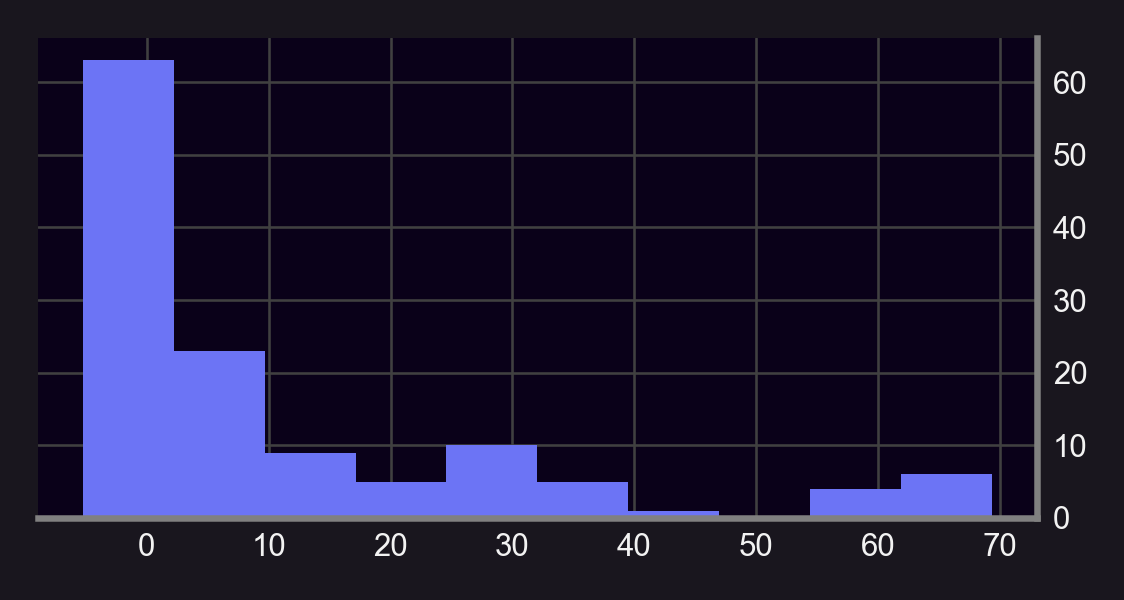

In [76]:
LVP = trades.copy(deep=True)
LVP['effective_spread_multiplier'] = LVP.apply(lambda x: get_pool_effective_spread(x['short_streamia_base'], x['short_streamia_spread']), axis=1)
LVP['lvp'] = LVP.apply(lambda x: (1 - 1.0 / x['effective_spread_multiplier']) * 100, axis=1)

LVP = LVP[(LVP.short_streamia_base != 0)]
LVP['lvp'].hist()

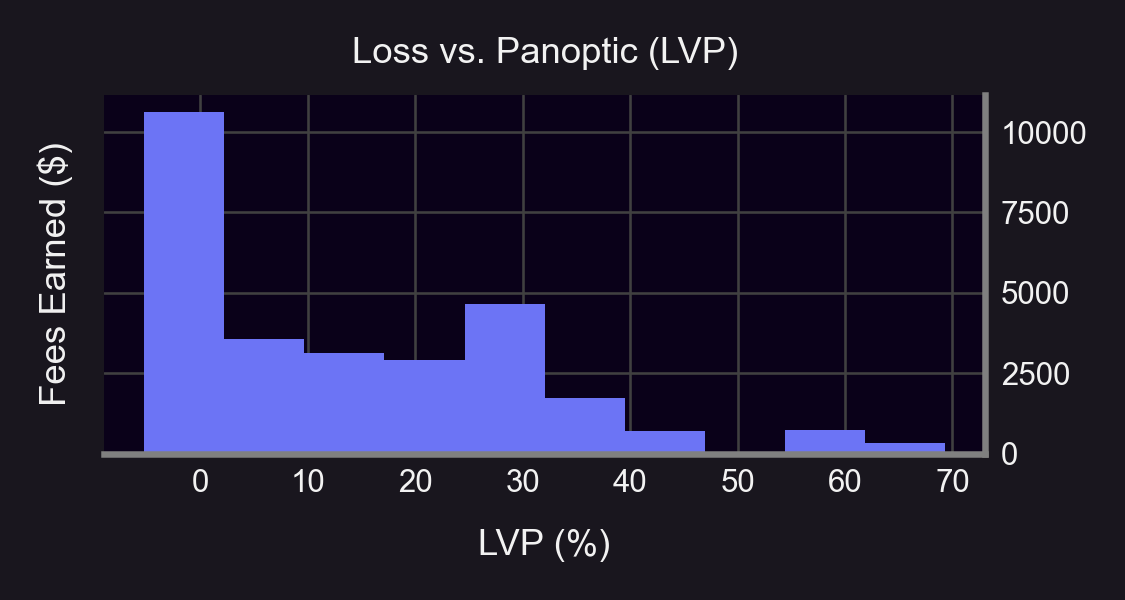

In [ ]:
LVP['lvp'].hist(weights=LVP["short_streamia_base"]+LVP['short_streamia_spread'])

plt.xlabel("LVP (%)")
plt.ylabel("Fees Earned ($)")
plt.title("Loss vs. Panoptic (LVP)")
# plt.savefig('C:/Users/lybra/github/panoptic/mainnet/ethereum/LVP-weighted-distribution.png', dpi=1000, bbox_inches="tight")

plt.show()

In [245]:
LVP[LVP.lvp > 0]['lvp'].describe()

count    85.000000
mean     17.558788
std      20.221399
min       0.000162
25%       2.065207
50%       8.281093
75%      25.412823
max      69.305332
Name: lvp, dtype: float64

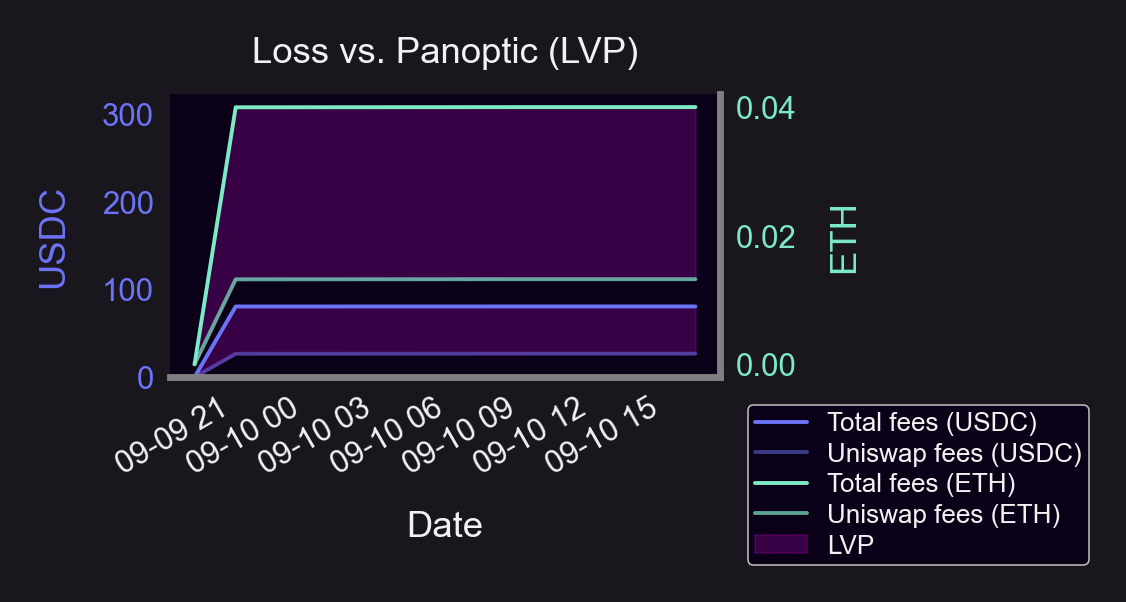

In [247]:
def plot_LVP(df: pd.DataFrame) -> None:
    df["timestamp"] = pd.to_datetime(df["block_number"], unit='s')

    df["spread_0"] = df["premium_0_spread"].fillna(0).cumsum()
    df["spread_1"] = df["premium_1_spread"].fillna(0).cumsum()
    df["base_0"] = df["premium_0_base"].fillna(0).cumsum()
    df["base_1"] = df["premium_1_base"].fillna(0).cumsum()
    df["total_0"] = df["base_0"] + df["spread_0"]
    df["total_1"] = df["base_1"] + df["spread_1"]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    c1 = colors[0]
    c2 = colors[1]
    c3 = colors[2]

    ax = df.plot(
        x="timestamp",
        y="total_0",
        color=c1,
        label="Total fees (USDC)",
        legend=False
    )

    df.plot(
        x="timestamp",
        y="base_0",
        ax=ax,
        color=c1,
        alpha=0.5,
        label="Uniswap fees (USDC)",
        legend=False
    )

    ax.fill_between(
        df["timestamp"],
        df["base_0"],
        df["total_0"],
        color=c3,
        alpha=0.2,
        label="LVP"
    )

    ax2 = df.plot(
        x="timestamp",
        y="total_1",
        secondary_y=True,
        ax=ax,
        color=c2,
        label="Total fees (ETH)",
        legend=False 
    )

    df.plot(
        x="timestamp",
        y="base_1",
        ax=ax2,
        color=c2,
        alpha=0.7,
        label="Uniswap fees (ETH)",
        secondary_y=True,
        legend=False
    )

    ax2.fill_between(
        df["timestamp"],
        df["base_1"],
        df["total_1"],
        color=c3,
        alpha=0.2,
        label="_nolegend_"
    )

    ax.set_xlabel('Date')
    ax.set_ylabel("USDC", color=c1)
    ax.tick_params(axis="y", labelcolor=c1)

    ax2.set_ylabel("ETH", color=c2)
    ax2.tick_params(axis="y", labelcolor=c2)

    handles_left, labels_left = ax.get_legend_handles_labels()
    handles_right, labels_right = ax2.get_legend_handles_labels()
    labels_right = [label.replace(" (right)", "") for label in labels_right]
    handles = handles_left + handles_right
    labels = labels_left + labels_right
    lvp_index = labels.index("LVP")
    # Pop the items
    lvp_handle = handles.pop(lvp_index)
    lvp_label = labels.pop(lvp_index)
    # Append them at the end
    handles.append(lvp_handle)
    labels.append(lvp_label)
    ax.legend(
        handles, 
        labels, 
        loc="upper left",
        bbox_to_anchor=(1.05, -0.1),
        borderaxespad=0.
    )
    ax.set_ylim(0, df["total_0"].max() * 4) 
    plt.title("Loss vs. Panoptic (LVP)")
    # plt.savefig('C:/Users/lybra/github/panoptic/mainnet/ethereum/LVP_example1.png', dpi=1000, bbox_inches="tight")

    plt.show()
plot_LVP(LVP[LVP.hash_open == '0x49eede50fb1c2f20ce62f5db5d07215fda66fb8e9077894d6f30b046ad51cc93']['streamia_df1'].iloc[0])
# plot_LVP(LVP[LVP.hash_open == '0xe0cb15f702dc9e6cfcb7cbc0e88a2987b2ba05a960c88ac915bd3f2ceaefe8eb']['streamia_df2'].iloc[0])

In [21]:
print(f'Effective spread multiplier: {effective_spread_multiplier}')
trades[['short_streamia_base', 'short_streamia_spread']].sum()

Effective spread multiplier: 1.1721341552058415


short_streamia_base      24236.260965
short_streamia_spread     4171.888307
dtype: float64

In [25]:
short_streamia_base, short_streamia_spread = trades[trades.short_streamia_spread != 0][['short_streamia_base', 'short_streamia_spread']].sum()
effective_spread_multiplier = get_pool_effective_spread(short_streamia_base, short_streamia_spread)
effective_spread_multiplier

1.198529630612686

In [27]:
short_streamia0_base, short_streamia0_spread = trades[trades.short_streamia_spread != 0][['short_streamia0_base', 'short_streamia0_spread']].sum()
effective_spread_multiplier = get_pool_effective_spread(short_streamia0_base, short_streamia0_spread)
effective_spread_multiplier

1.1925042618421993

In [29]:
short_streamia1_base, short_streamia1_spread = trades[trades.short_streamia_spread != 0][['short_streamia1_base', 'short_streamia1_spread']].sum()
effective_spread_multiplier = get_pool_effective_spread(short_streamia1_base, short_streamia1_spread)
effective_spread_multiplier

1.1880701617798437